In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import joblib

In [70]:
df = pd.read_csv("./Phishing_Email.csv")
df.iloc[150:160]

,Unnamed: 0,Email Text,Email Type
150,150,i believe all of you received a request from j...,Safe Email
151,151,Elias Sinderson wrote:\n > Heh. Never mind the...,Safe Email
152,152,> That has the nasty side effect of placing al...,Safe Email
153,153,SPECIAL ALERT<!--li.MsoNormal{mso-style-parent...,Phishing Email
154,154,conference announcement * * * * * * * * * * * ...,Safe Email
155,155,chamito - semitic conference announcing the 19...,Safe Email
156,156,for your information this will be our closing ...,Phishing Email
157,157,book on labelled deduction second call for pap...,Safe Email
158,158,"Dear Sir, \nWith due respect and humility I wr...",Phishing Email
159,159,anadarko and union pacific resources merged co...,Safe Email


In [25]:
df.isna().sum()

,0
Unnamed: 0,0
Email Text,16
Email Type,0


In [26]:
df = df.dropna()
print(df.isna().sum())

Unnamed: 0    0
Email Text    0
Email Type    0
dtype: int64


In [27]:
df.shape

(18634, 3)

In [28]:
df['Email Type'].value_counts()

,count
Email Type,
Safe Email,11322
Phishing Email,7312


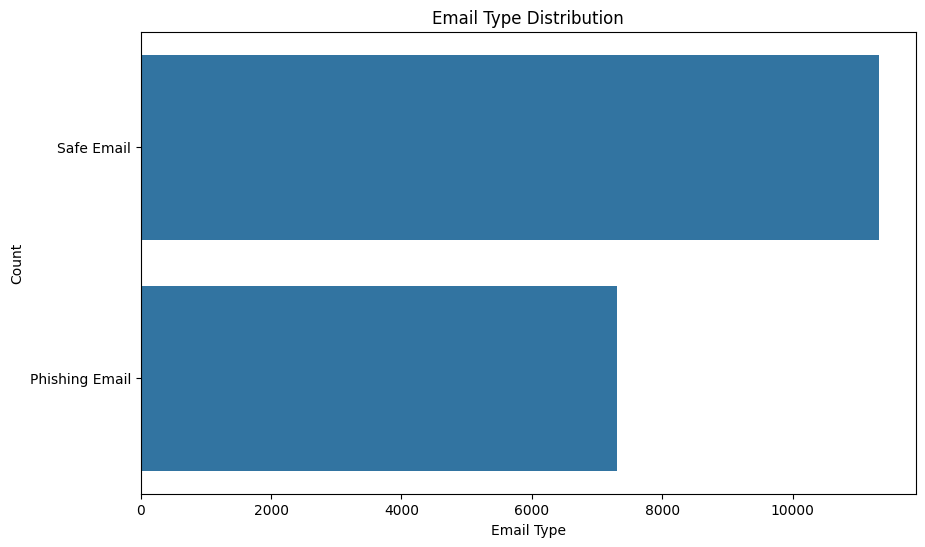

In [57]:
plt.figure(figsize=(10,6))
sns.countplot(df['Email Type'])
plt.title('Email Type Distribution')
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.show()

In [66]:
# for resampling

Safe_Email = df[df["Email Type"]== "Safe Email"]
Phishing_Email = df[df["Email Type"]== "Phishing Email"]
Safe_Email = Safe_Email.sample(Phishing_Email.shape[0])

In [61]:
Safe_Email.shape,Phishing_Email.shape

((7312, 3), (7312, 3))

In [62]:
Data= pd.concat([Safe_Email, Phishing_Email], ignore_index = True)
Data.head()

,Unnamed: 0,Email Text,Email Type
0,8476,"re : friday louise , we have been trying to ge...",Safe Email
1,3938,may hours survey attached please find the hour...,Safe Email
2,14230,"On Sun, 11 Aug 2002 bitbitch@magnesium.net wro...",Safe Email
3,12314,re : enron finance conference sponsorship this...,Safe Email
4,17462,"So, last night around 5:30AM I'm woken up by a...",Safe Email


In [64]:
Data.shape

(14624, 3)

In [65]:
X = Data["Email Text"].values
y = Data["Email Type"].values

In [67]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [77]:
models = [
    (Pipeline([("tfidf", TfidfVectorizer()), ("classifier", RandomForestClassifier())]), {'classifier__n_estimators': [10]}),
    (Pipeline([("tfidf", TfidfVectorizer()), ("classifier", DecisionTreeClassifier())]), {'classifier__max_depth': [None, 10]}),
    (Pipeline([("tfidf", TfidfVectorizer()), ("classifier", SGDClassifier())]), {'classifier__max_iter': [1000], 'classifier__tol': [1e-3]}),
    (Pipeline([("tfidf", TfidfVectorizer()), ("classifier", LogisticRegression())]), {'classifier__C': [1.0], 'classifier__max_iter': [100]})
]

*----* Model => RandomForestClassifier
Test Accuracy : 92.34275%
Classification Report
                precision    recall  f1-score   support

Phishing Email       0.90      0.96      0.93      2198
    Safe Email       0.95      0.89      0.92      2190

      accuracy                           0.92      4388
     macro avg       0.93      0.92      0.92      4388
  weighted avg       0.93      0.92      0.92      4388

Confusion Matrix


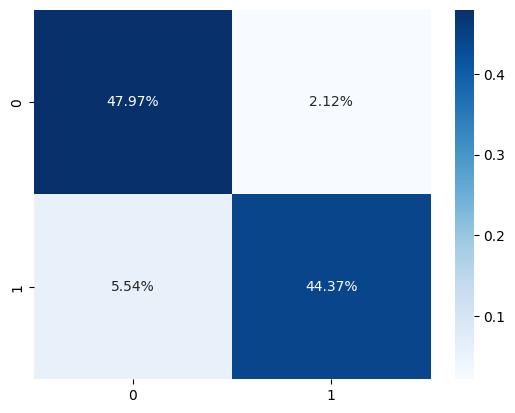

*---------------------------------*
*----* Model => DecisionTreeClassifier
Test Accuracy : 89.74476%
Classification Report
                precision    recall  f1-score   support

Phishing Email       0.89      0.91      0.90      2198
    Safe Email       0.91      0.88      0.90      2190

      accuracy                           0.90      4388
     macro avg       0.90      0.90      0.90      4388
  weighted avg       0.90      0.90      0.90      4388

Confusion Matrix


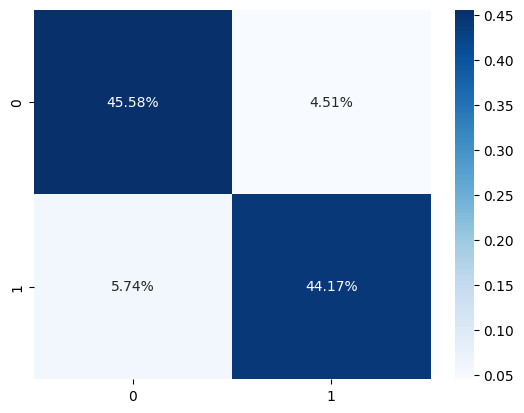

*---------------------------------*
*----* Model => SGDClassifier
Test Accuracy : 97.56153%
Classification Report
                precision    recall  f1-score   support

Phishing Email       0.96      0.99      0.98      2198
    Safe Email       0.99      0.96      0.98      2190

      accuracy                           0.98      4388
     macro avg       0.98      0.98      0.98      4388
  weighted avg       0.98      0.98      0.98      4388

Confusion Matrix


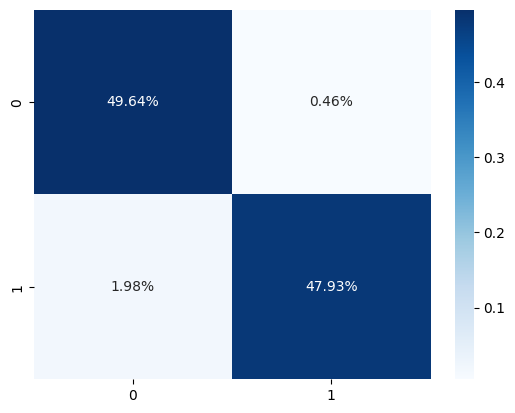

*---------------------------------*
*----* Model => LogisticRegression
Test Accuracy : 96.80948%
Classification Report
                precision    recall  f1-score   support

Phishing Email       0.95      0.98      0.97      2198
    Safe Email       0.98      0.95      0.97      2190

      accuracy                           0.97      4388
     macro avg       0.97      0.97      0.97      4388
  weighted avg       0.97      0.97      0.97      4388

Confusion Matrix


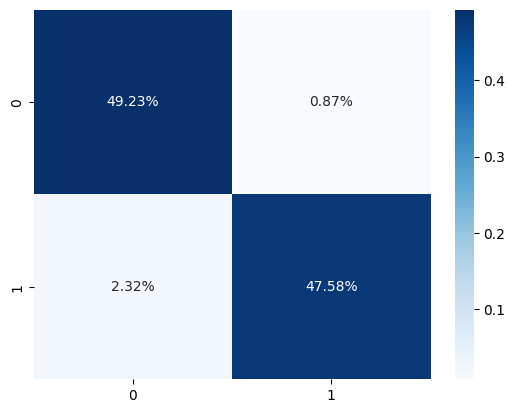

*---------------------------------*


In [80]:
accuracy_test = []
model_names = []

for pipeline, params in models:
    model_name = pipeline.steps[-1][1].__class__.__name__
    print(f'*----* Model => {model_name}')

    grid_search = GridSearchCV(pipeline, params, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    accuracy_test.append(acc)
    model_names.append(model_name)

    print(f'Test Accuracy : {acc*100:.5f}%')
    print('Classification Report')
    print(classification_report(y_test, pred))
    print('Confusion Matrix')
    cf_matrix = confusion_matrix(y_test, pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
    print('*---------------------------------*')

In [81]:
model_series = pd.Series(model_names, name='Model').astype(str)
accuracy_series = pd.Series(accuracy_test, name='Accuracy')

In [84]:
output = pd.concat([model_series, accuracy_series], axis=1)

In [85]:
output

,Model,Accuracy
0,RandomForestClassifier,0.923428
1,DecisionTreeClassifier,0.897448
2,SGDClassifier,0.975615
3,LogisticRegression,0.968095


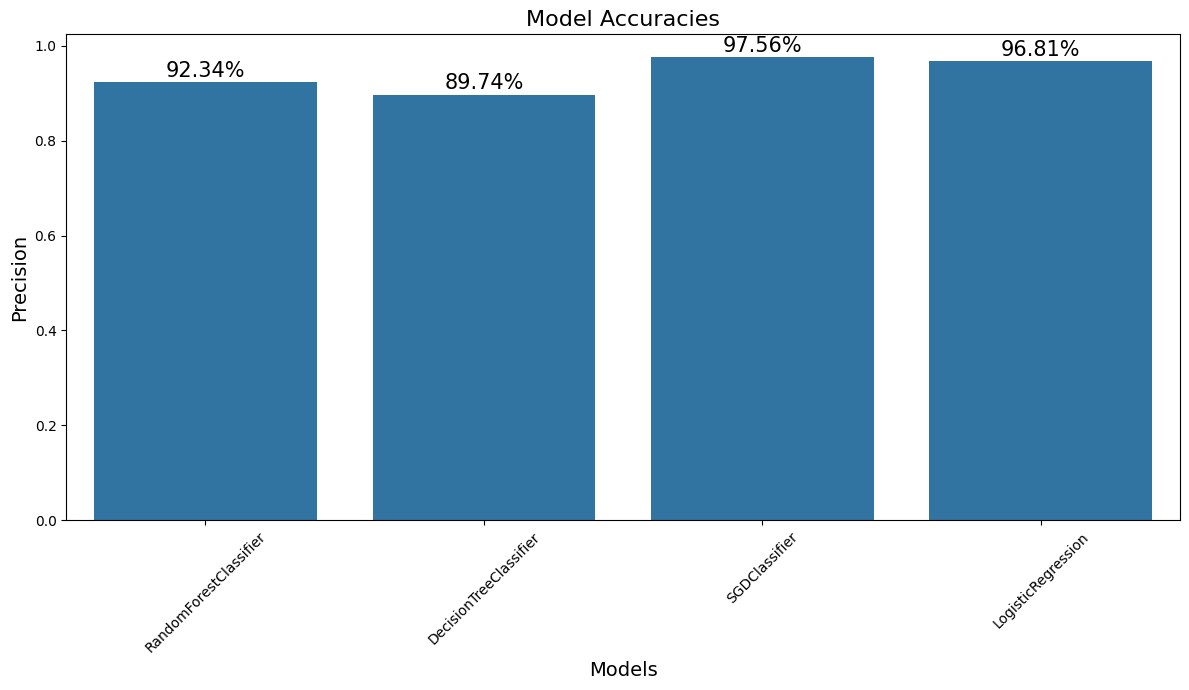

In [90]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2%'),
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                   ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Model Accuracies", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()

In [94]:
best_model

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', LogisticRegression())])

In [97]:
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']